**Intro: Installing and importing packages needed and data**

First, we install the common DS packages + the LIFELINES package. This is the one we will use for Survival Analysis.


In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install lifelines


     |████████████████████████████████| 348kB 2.8MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=ee6ea874c22275f41a506d009d26c8a1e1e1ec5b477fc9d04454603d11354533
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


Now we import the necessary packages: Lifelines for Survival Analysis; Pandas to deal with data manipulation and tables; Seaborn and Matplotlib for Data visualisation and Numpy for calculations.



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines
from lifelines import KaplanMeierFitter #survival analysis library
from lifelines.statistics import logrank_test #survival statistical testing



It's now time to import the dataset that you have downloaded. This is not a huge file, so should be quick enough. :D
This file is an open dataset available on [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn).


**Assigning the data and checking**


In [5]:
#This will take a minute. Afer this, everything is really fast. 
telco_data = pd.read_csv('https://raw.githubusercontent.com/Growth-Tribe/Survival/main/Telco-Customer-Churn.csv')

In [6]:
#We store our data on main_df, which stands for main data frame. 
main_df = telco_data
main_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Some of the columns have "Yes/No" as categories. We can convert those to Boolean (True/False) values.
Also, SeniorCitizen is not consistent with the nomenclature (1 or 0 instead of Yes or No). We need to convert that also.

In [7]:
main_df = main_df.replace({"Yes": True, "No": False})
main_df['SeniorCitizen'] = main_df['SeniorCitizen'].replace({1: True,0: False})

main_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,No phone service,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.95,1889.5,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,False,False,False,45,False,No phone service,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.70,151.65,True


Some features are based on others. For instance MultipleLines being "No phone service" is the same as False. If they don't have phone, then they for sure don't have MultipleLines. 
Same goes for OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies and the need for internet service. So "No internet service" can be coded as False as well.

In [8]:
main_df = main_df.replace({"No phone service": False, "No internet service": False})
main_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,False,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.95,1889.5,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,False,False,False,45,False,False,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.70,151.65,True


Let's check some information on this dataset.


In [ ]:
print ("Rows    : " , main_df.shape[0])
print ("Columns : " , main_df.shape[1])
print ("Features: \n" ,main_df.columns.tolist())
print ("Missing values :  ", main_df.isnull().sum().values.sum())
print ("Unique values :  \n",main_df.nunique())

In [ ]:
main_df.info()


"TotalCharges" should be Float (decimal numbers, not Strings). However, just trying to convert it returns a problem: some values are just white spaces and can't be converted to Float (check customerID 3213-VVOLG below as an example). 
 

In [ ]:
main_df.loc[main_df['customerID'] == '3213-VVOLG']

So we need to replace those for a NaN (Null) value first. We do this using REGEX.

In [9]:
main_df['TotalCharges'] = main_df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True)

#we can check the same customer again to make sure it worked
main_df.loc[main_df['customerID'] == '3213-VVOLG']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3826,3213-VVOLG,Male,False,True,True,0,True,True,False,False,False,False,False,False,False,Two year,False,Mailed check,25.35,NaN,False


"Gender", "InternetService", "Contract", "PaymentMethod" should be encoded as Categories, not Strings. And here we also change 'TotalCharges' to Float (decimal numbers).


In [10]:
main_df = main_df.astype({'gender': 'category', 
                          'InternetService': 'category', 
                          'Contract': 'category', 
                          'PaymentMethod': 'category', 
                          'TotalCharges': 'float64'})

main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   bool    
 3   Partner           7043 non-null   bool    
 4   Dependents        7043 non-null   bool    
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   bool    
 7   MultipleLines     7043 non-null   bool    
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   bool    
 10  OnlineBackup      7043 non-null   bool    
 11  DeviceProtection  7043 non-null   bool    
 12  TechSupport       7043 non-null   bool    
 13  StreamingTV       7043 non-null   bool    
 14  StreamingMovies   7043 non-null   bool    
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

Checking the categorical columns.

In [11]:
for column in main_df:
    if main_df[column].dtype.name == 'category':
        print("{}\n{}\n".format(main_df[column].name,pd.unique(main_df[column])))



gender
['Female', 'Male']
Categories (2, object): ['Female', 'Male']

InternetService
['DSL', 'Fiber optic', False]
Categories (3, object): ['DSL', 'Fiber optic', False]

Contract
['Month-to-month', 'One year', 'Two year']
Categories (3, object): ['Month-to-month', 'One year', 'Two year']

PaymentMethod
['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Categories (4, object): ['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
                         'Credit card (automatic)']



Getting lists for churned and non-churned users:

In [12]:
churned = main_df[main_df["Churn"] == True]
not_churned = main_df[main_df["Churn"] == False]

And then some descriptive statistics.

In [13]:
main_df.describe()


,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


Plotting Churn and Non-Churn distribution across Tenure.
The first one (FacetGrid) uses a density function, so you can notice how it goes "out of bounds" (less than 0 and more than 72 months).
The second one (histogram) is easier to interpret. No "out of bounds" shenanigans.


Text(0.5, 1.0, 'Churn distribution over Tenure')

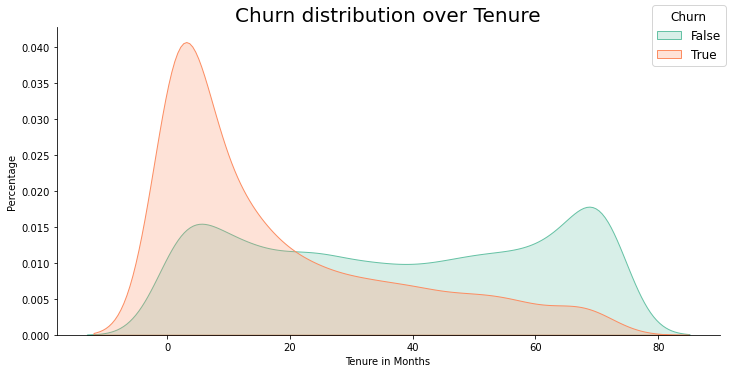

In [14]:
ax = sns.FacetGrid(main_df, hue='Churn',palette="Set2",aspect=2,height=5)
ax.map(sns.kdeplot, "tenure",shade= True)
ax.fig.legend(title='Churn',fontsize=12,title_fontsize=12)   
ax.set(xlabel="Tenure in Months",ylabel="Percentage")
plt.title('Churn distribution over Tenure', {'fontsize': 20})

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


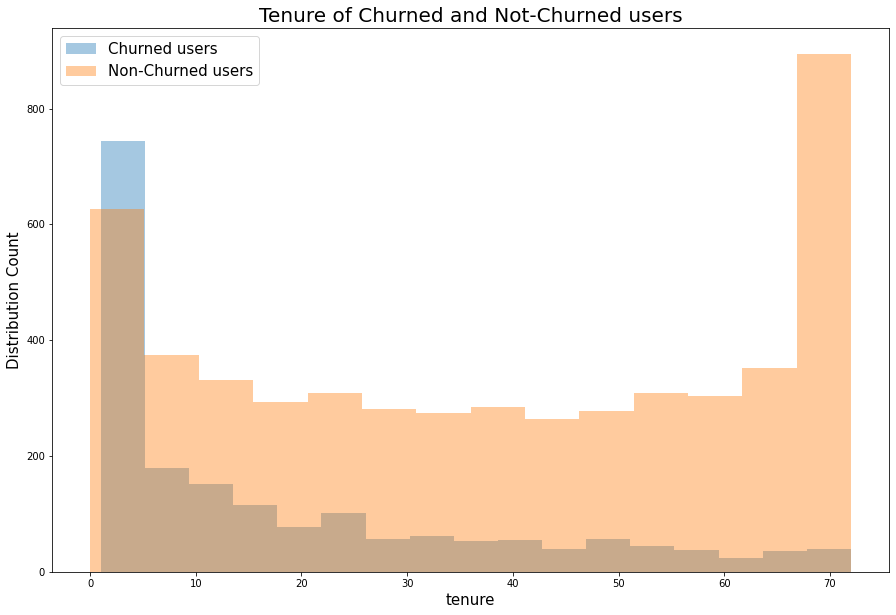

In [15]:
font = {'size':15}


plt.figure(figsize=(15,10))
plt.title("Tenure of Churned and Not-Churned users",fontdict={'size':20})
plt.xlabel("Tenure",fontdict=font)
plt.ylabel("Distribution Count",fontdict=font)
sns.distplot(churned["tenure"], kde=False, label="Churned users")
sns.distplot(not_churned["tenure"], kde=False, label="Non-Churned users")
plt.legend(loc="best",fontsize=15)


**Starting the Survival Analysis**

We will use the KaplanMeierFitter to fir and plot the survival function of this dataset.
T is the Tenure (in this case, the column 'tenure')
E is the Event (in this case, the column 'Churn')

In [16]:
kmf = KaplanMeierFitter()
T = main_df["tenure"]
E = main_df["Churn"]

kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7043 total observations, 5174 right-censored observations>

Let's plot it!

Text(0.5, 1.0, 'Survival function in TelCo')

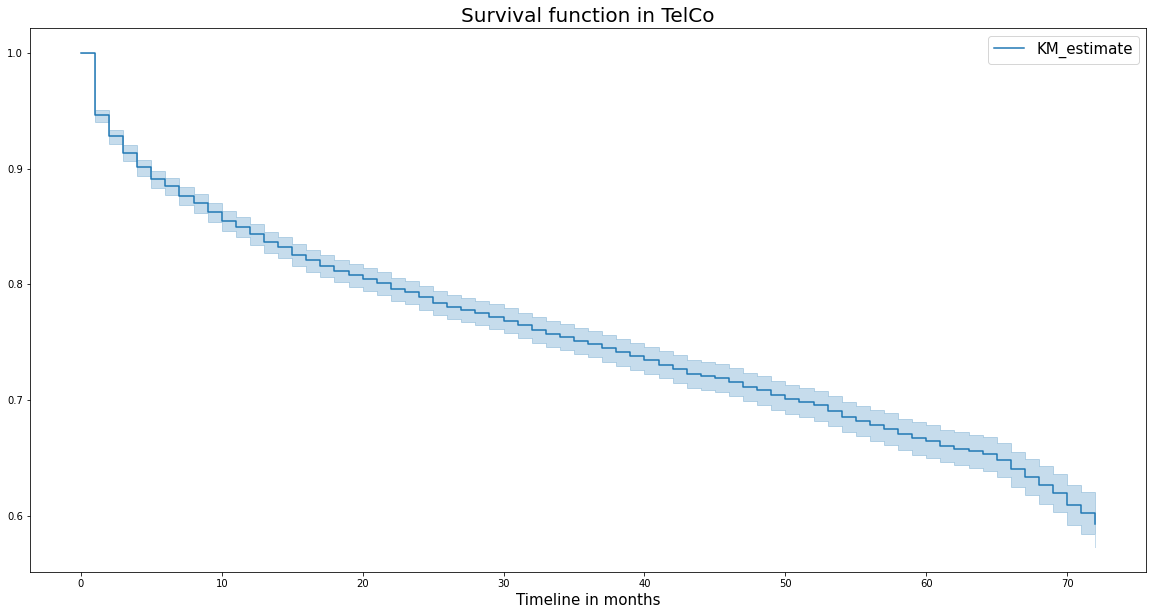

In [17]:
plt.figure(figsize=(20,10))


ax1 = kmf.plot()
plt.legend(fontsize=15)
plt.xlabel('Timeline in months',fontdict=font)
plt.title('Survival function in TelCo',fontdict={"size":20})




Text(0.5, 1.0, 'Survival function in TelCo')

<Figure size 1440x720 with 0 Axes>

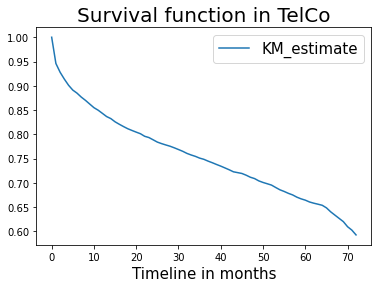

In [18]:
#or if you want a smooth curve
plt.figure(figsize=(20,10))

ax2 = kmf.survival_function_.plot()
plt.legend(fontsize=15)
plt.xlabel('Timeline in months',fontdict=font)
plt.title('Survival function in TelCo',fontdict={"size":20})
# plt.figure(figsize=(20,10))


Text(0.5, 0, 'Timeline in months')

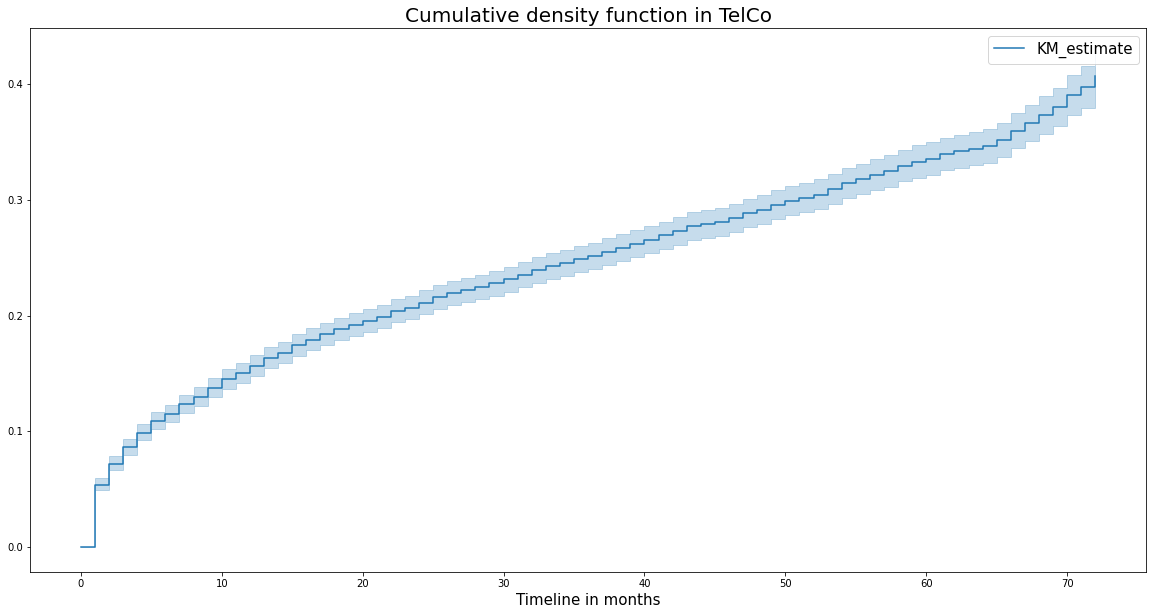

In [19]:
#or if you want to plot the cumulative density function
plt.figure(figsize=(20,10))

ax3 = kmf.plot_cumulative_density()
plt.legend(fontsize=15)
plt.title('Cumulative density function in TelCo',fontdict={"size":20})
plt.xlabel('Timeline in months',fontdict=font)


Notice that we don't have a median survival time, as we don't have a point when 50% of the users have churned. It returns 'inf' for infinity.

In [20]:
from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)

inf


We can stratify the Survival Function based on categories. One example, for instance, is checking the PaymentMethod or Contract.

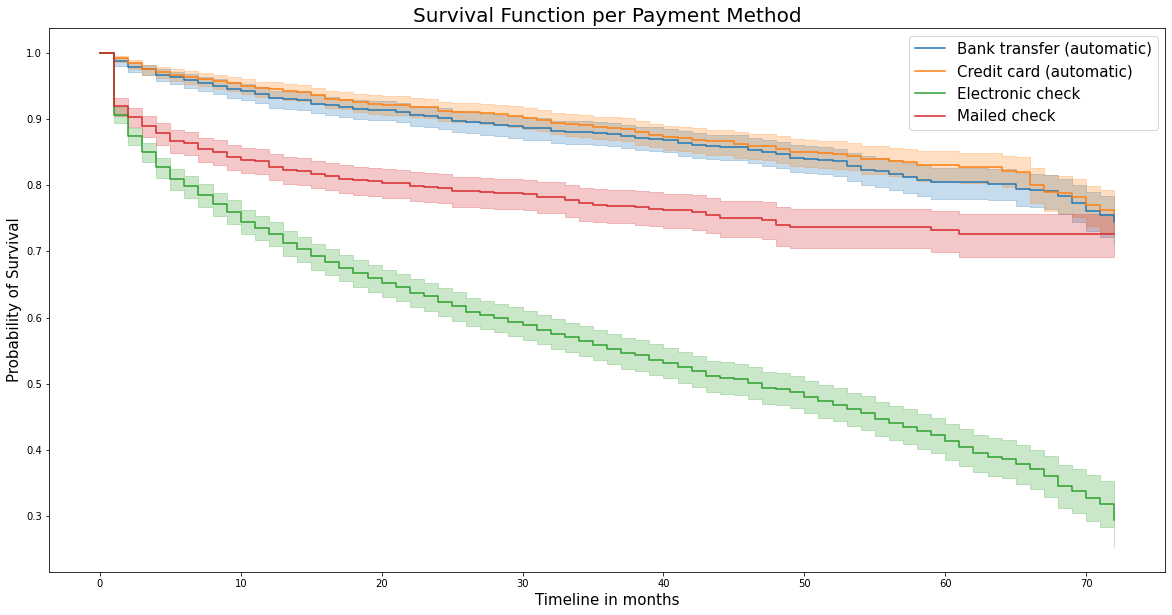

In [21]:
plt.figure(figsize=(20,10))

ax = plt.subplot(111)

kmf2 = KaplanMeierFitter()

for name, grouped_df in main_df.groupby('PaymentMethod'):
    kmf2.fit(grouped_df["tenure"], grouped_df["Churn"], label=name)
    kmf2.plot(ax=ax)

plt.title('Survival Function per Payment Method',fontdict={"size":20})
plt.xlabel('Timeline in months',fontdict=font)
plt.ylabel("Probability of Survival",fontdict=font)
plt.legend(fontsize=15)


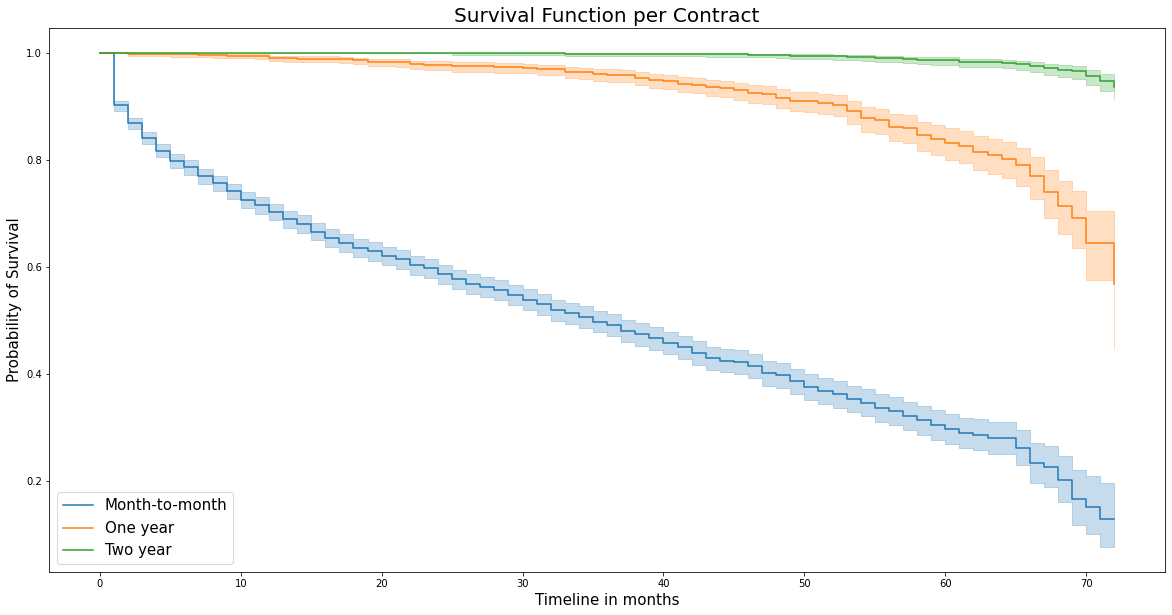

In [22]:
plt.figure(figsize=(20,10))

ax = plt.subplot(111)

kmf3 = KaplanMeierFitter()

for name, grouped_df in main_df.groupby('Contract'):
    kmf3.fit(grouped_df["tenure"], grouped_df["Churn"], label=name)
    kmf3.plot(ax=ax)

plt.title('Survival Function per Contract',fontdict={"size":20})
plt.xlabel('Timeline in months',fontdict=font)
plt.ylabel("Probability of Survival",fontdict=font)
plt.legend(fontsize=15)

**Hazard rates using Nelson-Aalen**

If we want to understand the hazard function *h(t)* of a population, we can use the Nelson Aalen estimator. It's a non-parametric estimator of the cumulative hazard function.

The interpretation is a bit less obvious here. The *rate of change* of the curve below is the estimate of the hazard function. 

          NA_estimate
timeline             
0.0          0.000000
1.0          0.055550
2.0          0.074896
3.0          0.090219
4.0          0.104193


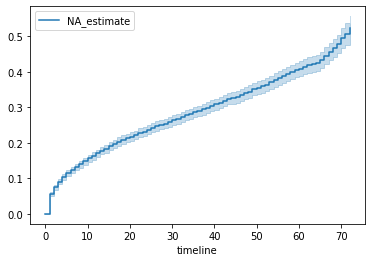

In [23]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(main_df["tenure"],event_observed=main_df["Churn"])

print(naf.cumulative_hazard_.head())
naf.plot()

We can do the same as before, and check the cumulative hazard based on certain categories.

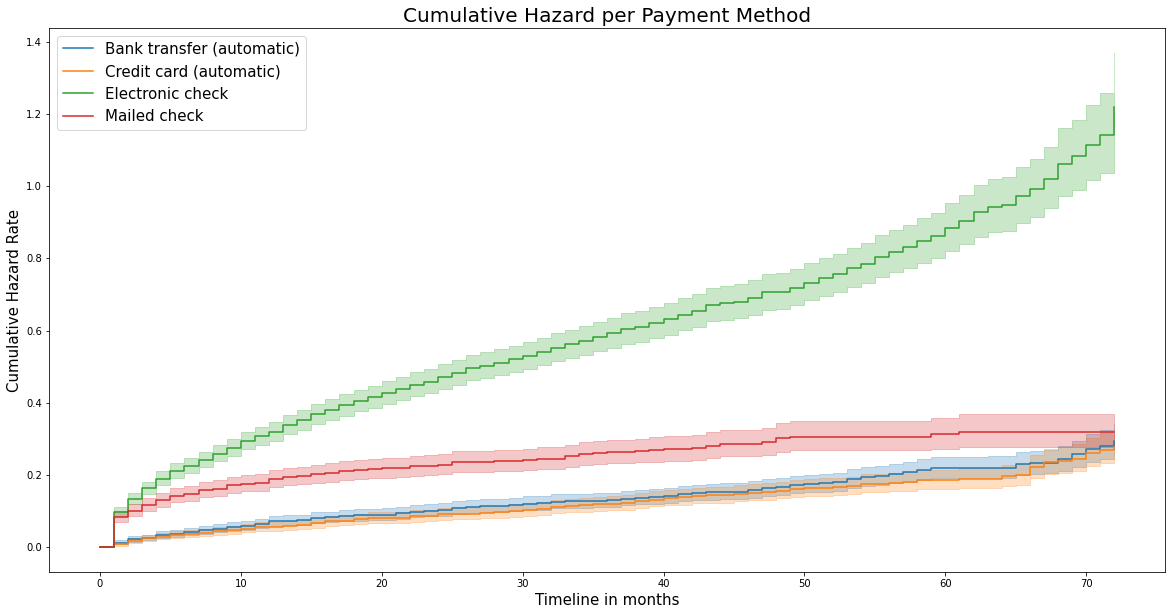

In [24]:
plt.figure(figsize=(20,10))

ax = plt.subplot(111)

naf2 = NelsonAalenFitter()

for name, grouped_df in main_df.groupby('PaymentMethod'):
    naf2.fit(grouped_df["tenure"], grouped_df["Churn"], label=name)
    naf2.plot(ax=ax)

plt.title('Cumulative Hazard per Payment Method',fontdict={"size":20})
plt.xlabel('Timeline in months',fontdict=font)
plt.ylabel("Cumulative Hazard Rate",fontdict=font)
plt.legend(fontsize=15)

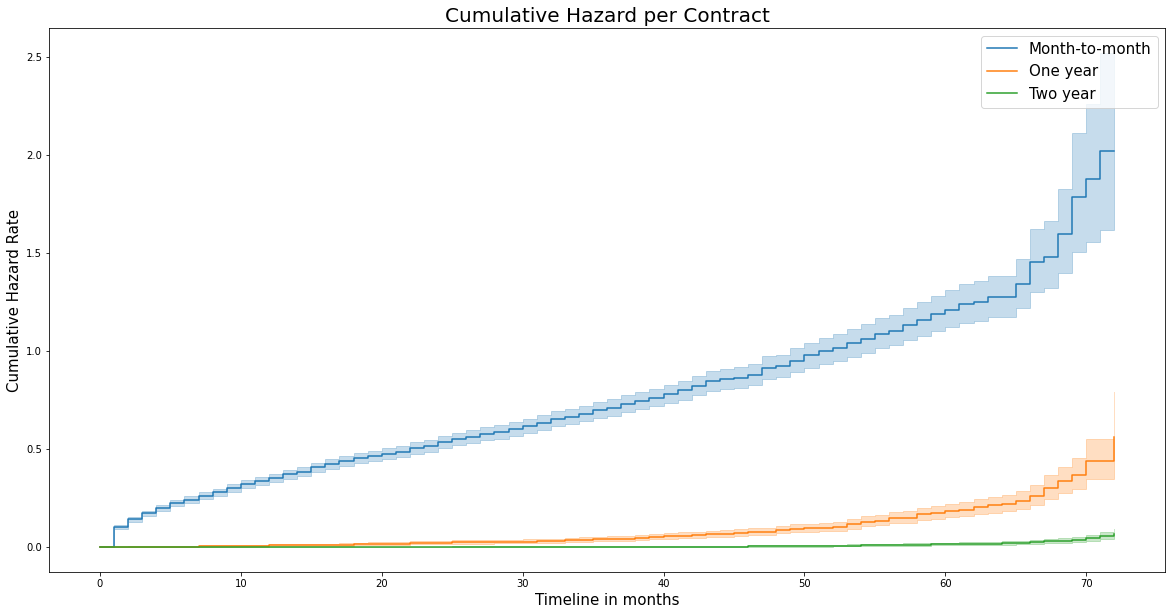

In [25]:
plt.figure(figsize=(20,10))

ax = plt.subplot(111)

naf3 = NelsonAalenFitter()

for name, grouped_df in main_df.groupby('Contract'):
    naf3.fit(grouped_df["tenure"], grouped_df["Churn"], label=name)
    naf3.plot(ax=ax)

plt.title('Cumulative Hazard per Contract',fontdict={"size":20})
plt.xlabel('Timeline in months',fontdict=font)
plt.ylabel("Cumulative Hazard Rate",fontdict=font)
plt.legend(fontsize=15)

**Survival Regression**

It's possible to infer survival on data that we set previously aside. This is called Survival Regression. We regress the features (covariates) such as Age, Senior, type of Internet Service, etc

For this, we need to dummify the data and remove features that won't be helpful in the regression (such as customerID).

In [26]:
main_df2 = main_df.replace({True: "Yes", False:"No"})
dummies = pd.get_dummies(
    main_df2[[
             "gender",
             "SeniorCitizen",
             "Partner",
             "Dependents",
             "PhoneService",
             "MultipleLines",
             "InternetService",
             "OnlineSecurity",
             "OnlineBackup",
             "DeviceProtection",
             "TechSupport",
             "PaymentMethod",
             "Contract",
             "Churn"
    ]],
    drop_first = True
)

new_df = dummies.join(main_df[["tenure","MonthlyCharges", "TotalCharges"]])
new_df = new_df.dropna()
new_df.head()


,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_One year,Contract_Two year,Churn_Yes,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85
1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,34,56.95,1889.50
2,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,2,53.85,108.15
3,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,45,42.30,1840.75
4,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,2,70.70,151.65


Applying the Cox Proportional Hazards Model now. It is a regression that considers how long that customer "survives". It's proportional because it shows how each feature increases risk over a baseline, proportionally.

We'll also use Scikit Learn for Train/Test split.

In [27]:
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split

cph = CoxPHFitter()

cph_train, cph_test = train_test_split(new_df, test_size=0.2)
cph.fit(cph_train, "tenure", "Churn_Yes")

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 5625 total observations, 4129 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_Yes'
      baseline estimation = breslow
   number of observations = 5625
number of events observed = 1496
   partial log-likelihood = -9815.20
         time fit was run = 2020-10-22 14:31:56 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
gender_Male                            -0.02       0.98       0.05            -0.12             0.08                 0.88                 1.08
SeniorCitizen_Yes                       0.02       1.02       0.06            -0.11             0.14                 0.90                 1.15
Partner_Yes                            -0.19       0.83       0.06            -0.31            -0.07                 0.73                 0.93
Dependents_Yes                         -0.10       0.91       0.08            -0.25             0.05                 0.78                 1.05
PhoneService_Yes                        0.25       1.29       0.13            -0.01             0.51                 0.99                 1.67
MultipleLines_Yes                      -0.04       0.97       0.06            -0.15             0.08                 0.86                 1.09
InternetService_Fiber optic             0.38       1.46       0.13             0.12             0.63                 1.13                 1.88
InternetService_No                     -1.71       0.18       0.19            -2.09            -1.33                 0.12                 0.27
OnlineSecurity_Yes                     -0.33       0.72       0.08            -0.48            -0.18                 0.62                 0.83
OnlineBackup_Yes                       -0.19       0.83       0.06            -0.31            -0.06                 0.73                 0.94
DeviceProtection_Yes                   -0.03       0.97       0.07            -0.16             0.10                 0.85                 1.10
TechSupport_Yes                        -0.21       0.81       0.08            -0.36            -0.06                 0.70                 0.94
PaymentMethod_Credit card (automatic)  -0.01       0.99       0.10            -0.21             0.19                 0.81                 1.21
PaymentMethod_Electronic check          0.39       1.48       0.08             0.23             0.56                 1.26                 1.75
PaymentMethod_Mailed check              0.55       1.73       0.10             0.36             0.74                 1.43                 2.10
Contract_One year                      -1.32       0.27       0.11            -1.55            -1.10                 0.21                 0.33
Contract_Two year                      -3.61       0.03       0.22            -4.04            -3.18                 0.02                 0.04
MonthlyCharges                          0.04       1.04       0.00             0.03             0.05                 1.03                 1.05
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                                           z      p   -log2(p)
covariate                                                     
gender_Male                            -0.42   0.68       0.57
SeniorCitizen_Yes                       0.27   0.79       0.34
Partner_Yes                            -3.06 <0.005       8.80
Dependents_Yes                         -1.29   0.20       2.34
PhoneService_Yes                        1.91   0.06       4.17
MultipleLines_Yes                      -0.58   0.57       0.82
InternetService_Fiber optic             2.93 <0.005       8.19
InternetService_No                     -8.78 <0.005      59.1

Interpretation of results: Concordance is 0.93 out of 1, which is very high. Meaning, the model is "in concordance" of the data seen.
For more info on Concordance, check this [paper](https://cran.r-project.org/web/packages/survival/vignettes/concordance.pdf) or these [slides](https://myweb.uiowa.edu/pbreheny/7210/f15/notes/11-19.pdf)
The most important coefficients are: 2 Year Contract, 1 Year Contract and InternetService_No.
Let's plot the coefficients.

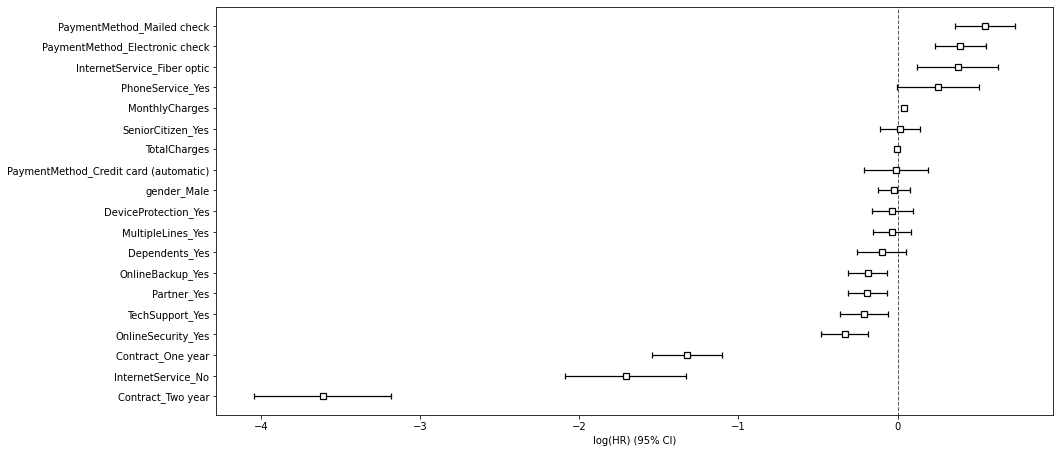

In [28]:
plt.figure(figsize=(15,7.5))

cph.plot()

Let's use the model in the test set!
We can see the concordance is still very high on the test set. It hasn't overfit the training set.

In [30]:
print(cph.score(cph_test, scoring_method = "concordance_index"))

0.9300251140210152


Let's try with cross-validation.

First score is the Log Likelihood.

Second score is the Concordance.




In [29]:
from lifelines.utils import k_fold_cross_validation

cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, new_df, 'tenure', event_col='Churn_Yes', k=3)
print(scores)

scores = k_fold_cross_validation(cph, new_df, 'tenure', event_col='Churn_Yes', k=3, scoring_method="concordance_index")
print(scores)

[-1.4993699244332628, -1.5291800687066792, -1.5066703408122628]
[0.9253447677850279, 0.929416767629761, 0.9299617676767162]


Similar results! And that is it for this Survival Analysis. Other models and possible visualizations exist,of course. Still, we were able to gather insights and the indicators of a customer churning, as well as the specific timeline.
Once you have the model, you can apply for specific users too. Check the Lifelines documentation to see how to do it. :)